In [1]:
import numpy as np
import pandas as pd
from os.path import join

from pylab import rcParams
import matplotlib.pyplot as plt
%matplotlib inline
rcParams['figure.figsize'] = (13, 6)
plt.style.use('ggplot')
import nilmtk
from nilmtk import DataSet, TimeFrame, MeterGroup, HDFDataStore
from nilmtk.disaggregate import CombinatorialOptimisation, fhmm_exact
from nilmtk.utils import print_dict
from nilmtk.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Vendor:  Continuum Analytics, Inc.
Package: mkl
Message: trial mode expires in 26 days


# Comparing FHMM and CO

## Downloading data

The full data set can be downloaded from the remote WikiEnergy database. The credentials are omitted here for security reasons.

In [2]:
# download_wikienergy(database_username, database_password, hdf_filename)

## Loading data

In [3]:
data_dir = '/Users/nipunbatra/Dropbox/nilmtk_datasets/'
we = DataSet(join(data_dir, 'redd.h5'))
print('loaded ' + str(len(we.buildings)) + ' buildings')

IOError: No such file as /Users/nipunbatra/Dropbox/nilmtk_datasets/redd.h5

In [4]:
building_number = 1
print_dict(we.buildings[building_number].metadata)

NameError: name 'we' is not defined

## Examine sub-metered appliances

In [5]:
elec = we.buildings[building_number].elec
elec.appliances

NameError: name 'we' is not defined

## Dividing data set into train and test

In [6]:
train = DataSet("/Users/nipunbatra/Dropbox/nilmtk_datasets/redd.h5")
test = DataSet("/Users/nipunbatra/Dropbox/nilmtk_datasets/redd.h5")

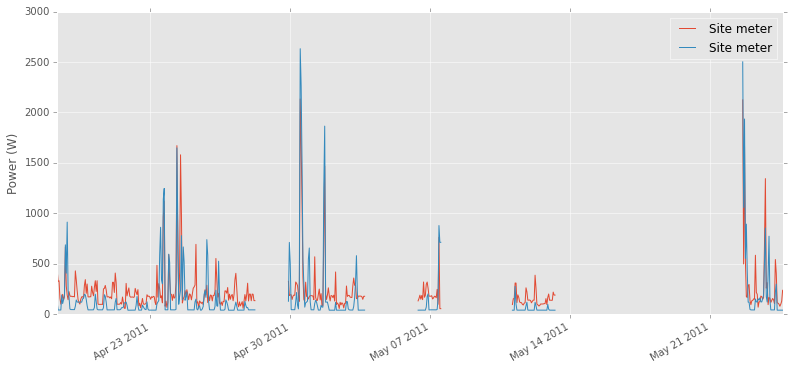

In [7]:
train.buildings[1].elec.mains().plot()

### Let's split data at April 30th

In [8]:
train.set_window(end="30-4-2011")
test.set_window(start="30-4-2011")

In [9]:
train_elec = train.buildings[1].elec
test_elec = test.buildings[1].elec

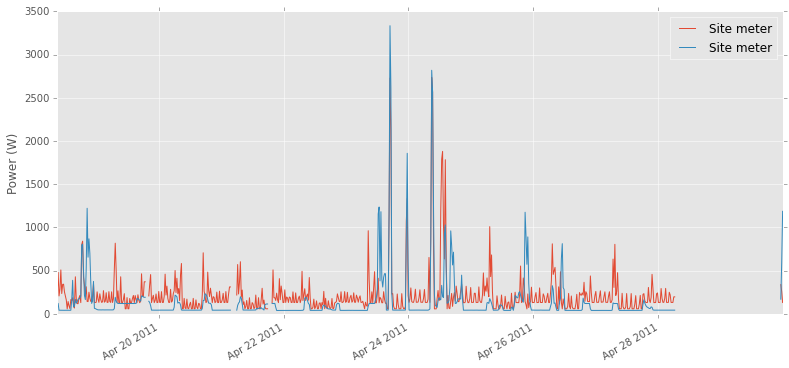

In [10]:
train_elec.mains().plot()

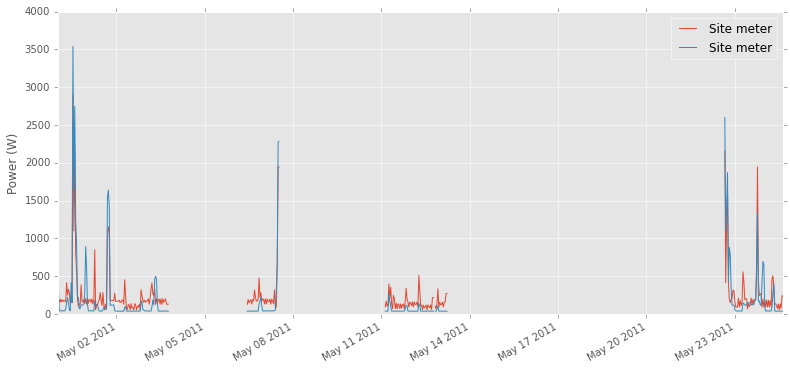

In [11]:
test_elec.mains().plot()

## Checking load_kwargs

In [12]:
m = train_elec['fridge']

In [13]:
df_raw = m.load().next()

In [14]:
df_raw.head(10)

physical_quantity          power
type                      active
2011-04-18 09:22:13-04:00      6
2011-04-18 09:22:16-04:00      6
2011-04-18 09:22:20-04:00      6
2011-04-18 09:22:23-04:00      6
2011-04-18 09:22:26-04:00      6
2011-04-18 09:22:30-04:00      6
2011-04-18 09:22:33-04:00      6
2011-04-18 09:22:37-04:00      6
2011-04-18 09:22:40-04:00      6
2011-04-18 09:22:44-04:00      6

In [15]:
df_1_min = m.power_series(sample_period=60).next()

In [16]:
df_1_min.head()

2011-04-18 09:22:00-04:00    6.0000
2011-04-18 09:23:00-04:00    6.0000
2011-04-18 09:24:00-04:00    6.0000
2011-04-18 09:25:00-04:00    5.9375
2011-04-18 09:26:00-04:00    5.9375
Freq: 60S, Name: (power, active), dtype: float64

## Selecting top-5 appliances

In [17]:
top_5_train_elec = train_elec.submeters().select_top_k(k=5)

15/16 MeterGroup(meters=
  ElecMeter(instance=3, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='REDD', appliances=[Appliance(type='electric oven', instance=1)])
16/16 MeterGroup(meters=
  ElecMeter(instance=10, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
  ElecMeter(instance=20, building=1, dataset='REDD', appliances=[Appliance(type='washer dryer', instance=1)])
Calculating total_energy for ElecMeterID(instance=20, building=1, dataset='REDD') ...   

In [18]:
top_5_train_elec

MeterGroup(meters=
  ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])
  ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])
  ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])
  ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])
)

## Training and disaggregation

### FHMM

Let us first train on raw data, no downsampling and see how much time it takes

In [19]:
import time

In [20]:
"""start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_5_train_elec)
end=time.time()
print end-start
"""

'start=time.time()\nfhmm = fhmm_exact.FHMM()\nfhmm.train(top_5_train_elec)\nend=time.time()\nprint end-start\n'

In [21]:
start=time.time()
fhmm = fhmm_exact.FHMM()
fhmm.train(top_5_train_elec, sample_period=60)
end=time.time()
print end-start

Training model for submeter 'ElecMeter(instance=5, building=1, dataset='REDD', appliances=[Appliance(type='fridge', instance=1)])'
Training model for submeter 'ElecMeter(instance=11, building=1, dataset='REDD', appliances=[Appliance(type='microwave', instance=1)])'
Training model for submeter 'ElecMeter(instance=8, building=1, dataset='REDD', appliances=[Appliance(type='sockets', instance=2)])'
Training model for submeter 'ElecMeter(instance=9, building=1, dataset='REDD', appliances=[Appliance(type='light', instance=1)])'
Training model for submeter 'ElecMeter(instance=6, building=1, dataset='REDD', appliances=[Appliance(type='dish washer', instance=1)])'
13.5836830139


In [22]:
disag_filename = join(data_dir, 'redd-disag-fhmm-new.h5')
output = HDFDataStore(disag_filename, 'w')
fhmm.disaggregate(test_elec.mains(), output, sample_period=60)
output.close()

Loading data for meter ElecMeterID(instance=2, building=1, dataset='REDD')     
Done loading data all meters for this chunk.


Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in Exception tables.exceptions.HDF5ExtError: HDF5ExtError('Problems closing the Group None',) in 

In [23]:
disag_filename = join(data_dir, 'redd-disag-fhmm-new.h5')
disag = DataSet(disag_filename)
disag_elec = disag.buildings[building_number].elec

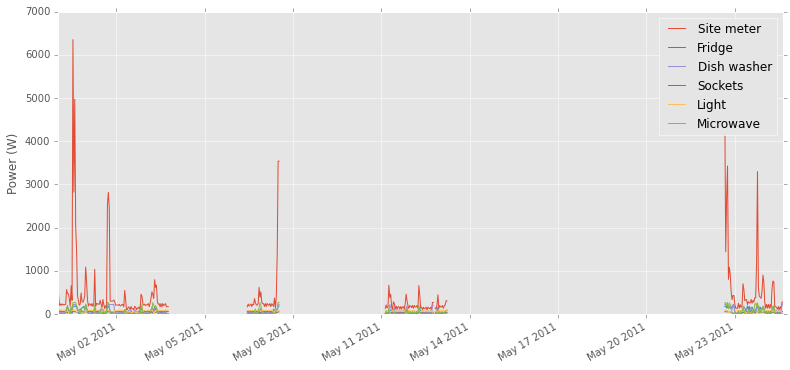

In [24]:
disag_elec.plot()

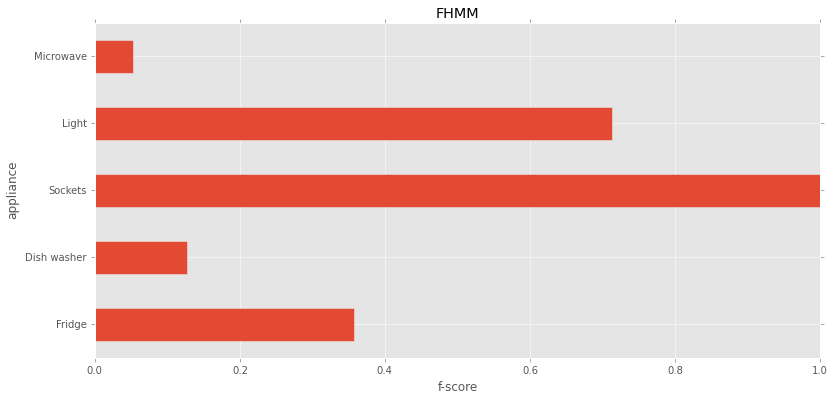

In [25]:
f1 = f1_score(disag_elec, test_elec)
f1.index = disag_elec.get_labels(f1.index)
f1.plot(kind='barh')
plt.ylabel('appliance');
plt.xlabel('f-score');
plt.title("FHMM");

In [17]:
# CSS styling
from IPython.core.display import display, HTML
display(HTML(open('static/styles.css', 'r').read()));